<a href="https://colab.research.google.com/github/Jackwangnao/Food-Classification---CNN/blob/master/ResNet_dropout_food_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun 23 23:51:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip show torch

Name: torch
Version: 1.5.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, future
Required-by: torchvision, torchtext, fastai


# 导入相关库

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import random
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 读取图片数据

由于是公开数据集，可通过以下方法直接下载，速度较快省去了上传数据集到谷歌硬盘的操作，更加简便

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下载数据集
!unzip food-11.zip # 解压缩

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  inflating: food-11/training/6_289.jpg  
  i

## 定义读取图片的函数 `readfile()`

用`OpenCV（cv2）`读取图片并存放在`numpy.ndarray`中

In [ ]:
def readfile(path, label):
    # label 是一个布尔值，代表需不需要返回 y 值
    image_dir = sorted(os.listdir(path))
    # x存储图片，每张彩色图片都是128(高)*128(宽)*3(彩色三通道)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    # y存储标签，每个y大小为1
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        # 利用cv2.resize()函数将不同大小的图片统一为128(高)*128(宽)
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

## 用函数`readfile()` 读取  `training set`、`validation set`、`testing set`

In [ ]:
#分别将 training set、validation set、testing set 用函数 readfile() 读进来
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# 定义Dataset

In [ ]:
#training 时，通过随机旋转、水平翻转图片来进行数据增强（data augmentation）
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), #随机翻转图片
    transforms.RandomRotation(15), #随机旋转图片
    transforms.ToTensor(), #将图片变成 Tensor，并且把数值normalize到[0,1]
])
#testing 时，不需要进行数据增强（data augmentation）
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label 需要是 LongTensor 型
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# 定义模型

## 定义残差块

In [ ]:
# 定义残差块
class Residual_Block(nn.Module):
    def __init__(self, i_channel, o_channel, stride=1, down_sample=None):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=i_channel,
                               out_channels=o_channel,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # BatchNorm2d(）对小批量3d数据组成的4d输入进行批标准化操作
        # 主要为了防止神经网络退化
        self.bn1 = nn.BatchNorm2d(o_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=o_channel,
                               out_channels=o_channel,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # 将单元的输入直接与单元输出加在一起
        if self.down_sample:
            residual = self.down_sample(x)  # 下采样
        out += residual
        out = self.relu(out)

        return out

## 定义残差神经网络

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=11):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.in_channels = 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # dropout

    def make_layer(self, block, out_channels, blocks, stride=1):
        # blocks=layers,残差模块的数量
        down_sample = None
        # 判断是否in_channels(输入)与(输出)是否在同一维度
        # 即输入的3d数据的长宽高与输出的数据的长宽高是否一样
        if (stride != 1) or (self.in_channels != out_channels):
            # 如果不一样就转换一下维度
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, down_sample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)  # 添加所有残差块

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out)  # dropout
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

# 训练 

## 使用训练集`train set`训练，同步使用验证集`validation set`验证

In [ ]:
# 超参数设定
batch_size = 128
learning_rate = 1e-3

# 加载训练集、验证集
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

model = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
loss = nn.CrossEntropyLoss()  # 因为是分类任务，所以使用交叉熵损失

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 使用Adam优化器
num_epoch = 100  # 迭代次数

# 保存每个iteration的loss和accuracy，以便后续画图
train_loss_record = [] # 记录每代训练集的loss
val_loss_record = [] # 记录每代验证集的loss
train_acc_record = [] # 记录每代训练集的accuracy
val_acc_record = [] # 记录每代验证集的accuracy

# 用测试集训练模型model(),用验证集作为测试集来验证
curr_lr = learning_rate
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()  # 确保 model 是在 训练 model (开启 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()  # 用 optimizer 将模型参数的梯度 gradient 归零
        train_pred = model(data[0].cuda())  # 利用 model 得到预测的概率分布，这边实际上是调用模型的 forward 函数
        batch_loss = loss(train_pred, data[1].cuda())  # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward()  # 利用 back propagation 算出每个参数的 gradient
        optimizer.step()  # 以 optimizer 用 gradient 更新参数

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    # 验证集val
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        # 保存用于画图
        train_acc_record.append(train_acc / train_set.__len__())
        train_loss_record.append(train_loss / train_set.__len__())
        val_acc_record.append(val_acc / val_set.__len__())
        val_loss_record.append(val_loss / val_set.__len__())

        # 将结果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
              (epoch + 1, num_epoch, time.time() - epoch_start_time, \
               train_acc_record[-1], train_loss_record[-1], val_acc_record[-1], val_loss_record[-1]))

[001/100] 21.21 sec(s) Train Acc: 0.274579 Loss: 0.016292 | Val Acc: 0.352478 loss: 0.014385
[002/100] 21.24 sec(s) Train Acc: 0.380093 Loss: 0.014186 | Val Acc: 0.381341 loss: 0.014375
[003/100] 21.27 sec(s) Train Acc: 0.419826 Loss: 0.013306 | Val Acc: 0.434694 loss: 0.013367
[004/100] 21.26 sec(s) Train Acc: 0.449321 Loss: 0.012464 | Val Acc: 0.448980 loss: 0.012829
[005/100] 21.23 sec(s) Train Acc: 0.484492 Loss: 0.011796 | Val Acc: 0.453936 loss: 0.012444
[006/100] 21.23 sec(s) Train Acc: 0.506386 Loss: 0.011307 | Val Acc: 0.486006 loss: 0.011994
[007/100] 21.22 sec(s) Train Acc: 0.533448 Loss: 0.010749 | Val Acc: 0.467347 loss: 0.013163
[008/100] 21.25 sec(s) Train Acc: 0.546523 Loss: 0.010603 | Val Acc: 0.475802 loss: 0.012334
[009/100] 21.22 sec(s) Train Acc: 0.561423 Loss: 0.010168 | Val Acc: 0.473178 loss: 0.012536
[010/100] 21.21 sec(s) Train Acc: 0.579972 Loss: 0.009703 | Val Acc: 0.515743 loss: 0.012227
[011/100] 21.21 sec(s) Train Acc: 0.589803 Loss: 0.009546 | Val Acc: 0

Text(0.5, 1.0, 'Loss curve')

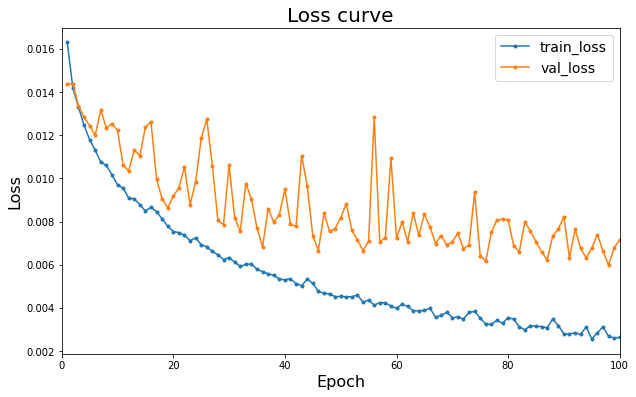

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], train_loss_record, '.-', label='train_loss')
ax.plot([epoch+1 for epoch in range(num_epoch)], val_loss_record, '.-', label='val_loss')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Loss curve',fontsize=20)

Text(0.5, 1.0, 'Accuracy curve')

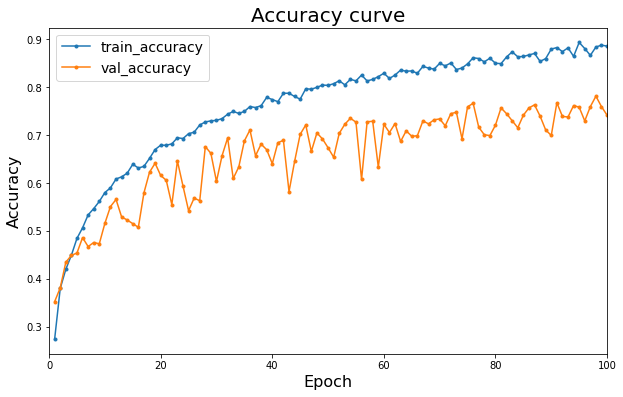

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], train_acc_record, '.-', label='train_accuracy')
ax.plot([epoch+1 for epoch in range(num_epoch)], val_acc_record, '.-', label='val_accuracy')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Accuracy curve',fontsize=20)

## 使用训练集 `training set` 和验证集 `validation set`
仅使用训练集进行训练模型效果还可以，说明定义的模型可行，这里将训练集和验证集一起用来训练模型，数据量更大，应该模型表现会更好

In [ ]:
train_val_x = np.concatenate((train_x, val_x), axis=0)  # 将train_x和val_x拼接起来
train_val_y = np.concatenate((train_y, val_y), axis=0)  # 将train_y和val_y拼接起来
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [ ]:
model_best = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
loss = nn.CrossEntropyLoss()  # 因为是分类任务，所以使用交叉熵损失
optimizer = torch.optim.Adam(model_best.parameters(), lr=learning_rate)  # 使用Adam优化器
num_epoch = 100  # 迭代次数
# 保存每个iteration的loss和accuracy，以便后续画图
loss_record = [] # 记录每代的loss
acc_record = []  # 记录每代的accuracy

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    # 将结果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))
    
    acc_record.append(train_acc / train_val_set.__len__())
    loss_record.append(train_loss / train_val_set.__len__())

[001/100] 25.78 sec(s) Train Acc: 0.287681 Loss: 0.015930
[002/100] 25.82 sec(s) Train Acc: 0.393953 Loss: 0.013588
[003/100] 25.80 sec(s) Train Acc: 0.447353 Loss: 0.012499
[004/100] 25.73 sec(s) Train Acc: 0.485560 Loss: 0.011743
[005/100] 25.80 sec(s) Train Acc: 0.516622 Loss: 0.011032
[006/100] 25.79 sec(s) Train Acc: 0.535725 Loss: 0.010599
[008/100] 25.80 sec(s) Train Acc: 0.574684 Loss: 0.009753
[009/100] 25.88 sec(s) Train Acc: 0.587094 Loss: 0.009446
[010/100] 25.87 sec(s) Train Acc: 0.611236 Loss: 0.008907
[011/100] 25.75 sec(s) Train Acc: 0.623120 Loss: 0.008715
[012/100] 25.81 sec(s) Train Acc: 0.630791 Loss: 0.008446
[013/100] 25.73 sec(s) Train Acc: 0.651474 Loss: 0.008079
[014/100] 25.57 sec(s) Train Acc: 0.661026 Loss: 0.007861
[015/100] 25.58 sec(s) Train Acc: 0.676143 Loss: 0.007599
[016/100] 25.52 sec(s) Train Acc: 0.679452 Loss: 0.007385
[017/100] 25.47 sec(s) Train Acc: 0.695171 Loss: 0.007133
[018/100] 25.55 sec(s) Train Acc: 0.699835 Loss: 0.007030
[019/100] 25.4

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Loss curve')

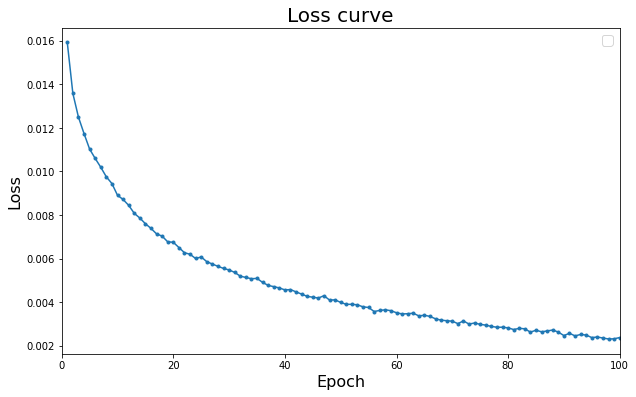

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], loss_record, '.-')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.set_title('Loss curve',fontsize=20)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Accuracy curve')

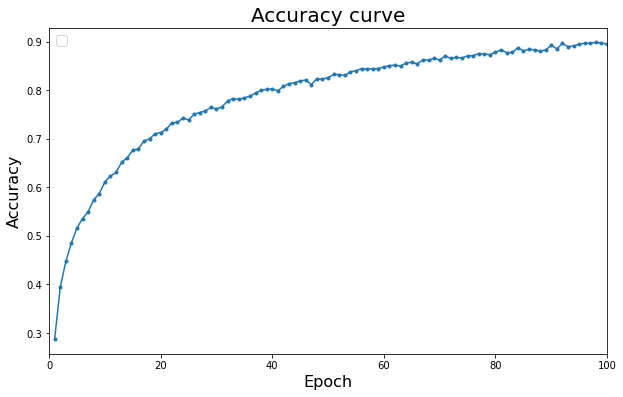

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], acc_record, '.-')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.set_title('Accuracy curve',fontsize=20)

# 测试

用刚才训练好的模型，在`test set`上进行测试。

In [ ]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
model_best.eval()
test_prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        # 预测值中概率最大的下标即为模型预测的食物标签
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            test_prediction.append(y)

In [ ]:
#将预测结果写入 csv 
from google.colab import drive
drive.mount('drive')
test_predict_result = pd.DataFrame({'Id':np.arange(len(test_x)).tolist(), 'Category': test_prediction})
test_predict_result.to_csv('ResNet_dropout_food_classification_CNN.csv', index=False)
!cp ResNet_dropout_food_classification_CNN.csv drive/My\ Drive/Colab\ Output\ File/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# 误差矩阵

In [ ]:
# 得到训练集和验证集的预测值
train_val_x_set = ImgDataset(train_val_x, transform=test_transform)
train_val_x_loader = DataLoader(train_val_x_set, batch_size=batch_size, shuffle=False)

model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(train_val_x_loader):
        train_val_pred = model_best(data.cuda())
        # 预测值中概率最大的下标即为模型预测的食物标签
        train_val_label = np.argmax(train_val_pred.cpu().data.numpy(), axis=1)
        for y in train_val_label:
            prediction.append(y)

In [ ]:
# 计算误差矩阵
matrix = metrics.confusion_matrix(train_val_y,prediction)
matrix_prop = matrix / matrix.sum(axis=1).reshape(11, -1)

Text(0.5, 1.0, 'Confusion matrix')

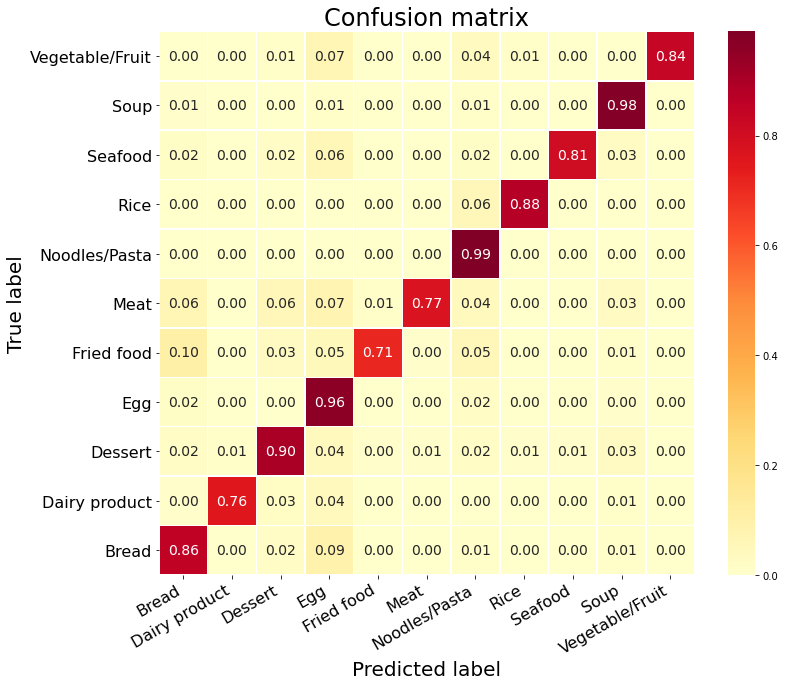

In [ ]:
# 绘制误差矩阵图
f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(matrix_prop, annot=True, annot_kws={'size': 14}, fmt='.2f', cmap='YlOrRd',
            linewidths=.5, ax=ax)

ax.set_ylim([0, 11])
ax.set_xticks(np.arange(11) + 0.5)
ax.set_xticklabels(['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 
                    'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 
                    'Vegetable/Fruit'], rotation=30, ha='right')
ax.set_yticks(np.arange(11) + 0.5)
ax.set_yticklabels(['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 
                    'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 
                    'Vegetable/Fruit'], rotation=0)
plt.tick_params(labelsize=16)
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('True label',fontsize=20)
ax.set_title('Confusion matrix', {'size': 24})